<a href="https://colab.research.google.com/github/Lucas-Siade/Data-Science/blob/main/Codes/Supervisionado/DS%20-%20Rede%20Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exemplo**

## **Bibliotecas**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

## **Dataset**

In [4]:
datasetRedeNeural = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/Dataset - Heart Disease.csv")

#DEFINIÇÃO DAS COLUNAS
datasetRedeNeural.rename(columns={
    'Age': 'Idade',
    'Sex': 'Sexo',
    'ChestPainType': 'Tipo de Dor no Peito',
    'RestingBP': 'Pressão em Repouso',
    'Cholesterol': 'Colesterol',
    'FastingBS': 'Glicemia em Jejum',
    'RestingECG': 'ECG em Repouso',
    'MaxHR': 'Frequência Máxima',
    'ExerciseAngina': 'Angina Esforço',
    'Oldpeak': 'Depressão ST',
    'ST_Slope': 'Inclinação ST',
    'HeartDisease': 'Doença Cardíaca'
}, inplace=True)

#TRADUÇÃO DOS VALORES
substituicoes = {
    'Sexo': {
        'M': 'Masculino',
        'F': 'Feminino'
    },
    'Tipo de Dor no Peito': {
        'ATA': 'Angina Atípica',
        'NAP': 'Dor Não-Anginosa',
        'ASY': 'Assintomático',
        'TA': 'Angina Típica'
    },
    'ECG em Repouso': {
        'Normal': 'Normal',
        'ST': 'Anormalidade ST',
        'LVH': 'Hipertrofia Ventricular'
    },
    'Angina Esforço': {
        'N': 'Não',
        'Y': 'Sim'
    },
    'Inclinação ST': {
        'Up': 'Ascendente',
        'Flat': 'Plana',
        'Down': 'Descendente'
    },
    'Doença Cardíaca': {
        0: 'Não',
        1: 'Sim'
    }
}

for coluna, mapping in substituicoes.items():
    datasetRedeNeural[coluna] = datasetRedeNeural[coluna].map(mapping)

display(datasetRedeNeural.head())

,Idade,Sexo,Tipo de Dor no Peito,Pressão em Repouso,Colesterol,Glicemia em Jejum,ECG em Repouso,Frequência Máxima,Angina Esforço,Depressão ST,Inclinação ST,Doença Cardíaca
0,40,Masculino,Angina Atípica,140,289,0,Normal,172,Não,0.0,Ascendente,Não
1,49,Feminino,Dor Não-Anginosa,160,180,0,Normal,156,Não,1.0,Plana,Sim
2,37,Masculino,Angina Atípica,130,283,0,Anormalidade ST,98,Não,0.0,Ascendente,Não
3,48,Feminino,Assintomático,138,214,0,Normal,108,Sim,1.5,Plana,Sim
4,54,Masculino,Dor Não-Anginosa,150,195,0,Normal,122,Não,0.0,Ascendente,Não


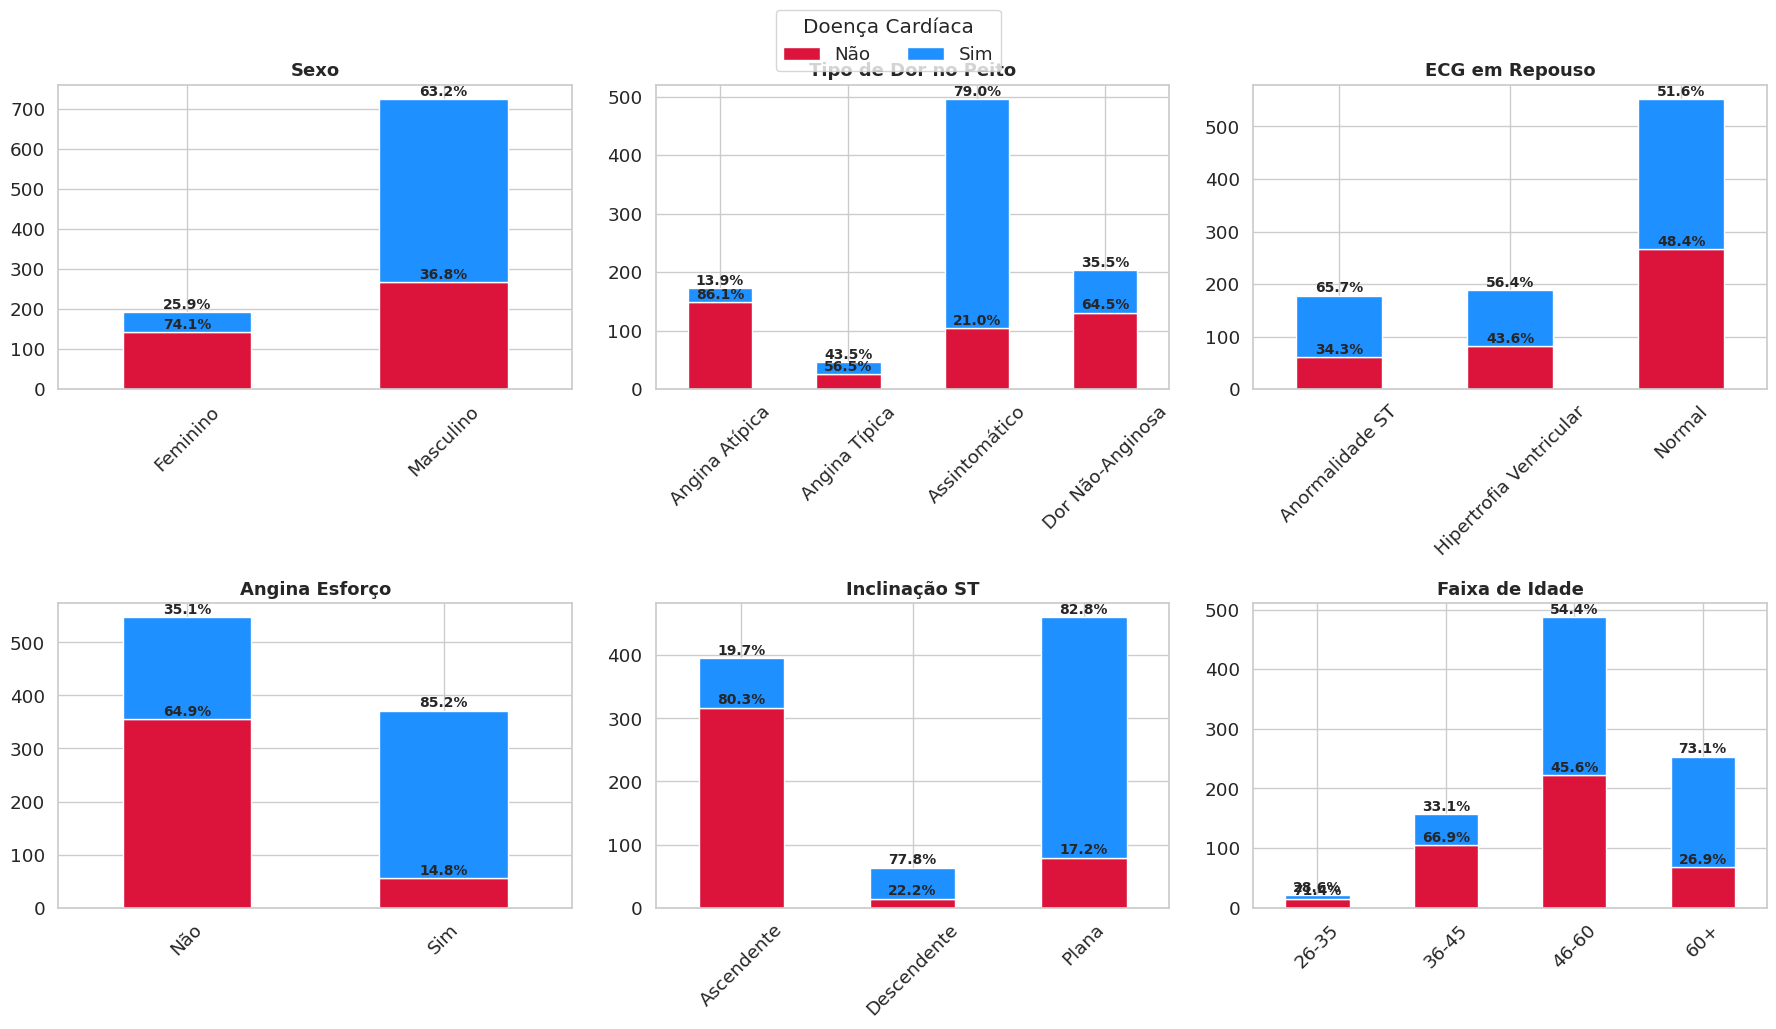

In [5]:
#AGRUPAR IDADES
bins = [18, 25, 35, 45, 60, 100]
labels = ['18-25', '26-35', '36-45', '46-60', '60+']
datasetRedeNeural['Faixa de Idade'] = pd.cut(datasetRedeNeural['Idade'], bins=bins, labels=labels, right=False)

colunas_cat = datasetRedeNeural.select_dtypes(include=['object', 'category']).columns.tolist()
colunas_cat.remove('Doença Cardíaca')
total_colunas = len(colunas_cat)

cols = 3
rows = (total_colunas + cols - 1) // cols

sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, coluna in enumerate(colunas_cat):

    ax = axes[i]

    contagem = datasetRedeNeural.groupby([coluna, "Doença Cardíaca"], observed=True).size().unstack(fill_value=0)

    contagem = contagem.reindex(columns=['Não', 'Sim'], fill_value=0)

    contagem.plot(
        kind='bar',
        stacked=True,
        color=['crimson', 'dodgerblue'],
        ax=ax,
        legend=False
    )

    for idx, categoria in enumerate(contagem.index):
        total = contagem.loc[categoria].sum()

        altura_acumulada = 0
        for risco, cor in zip(['Não', 'Sim'], ['crimson', 'dodgerblue']):
            valor = contagem.loc[categoria, risco]
            if valor > 0:
                percentual = (valor / total) * 100
                y_offset = altura_acumulada + valor
                ax.text(
                    idx,
                    y_offset + 1,
                    f"{percentual:.1f}%",
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    weight='bold'
                )
                altura_acumulada += valor

                ax.set_title(coluna, fontsize=13, fontweight='bold')

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.legend(['Não', 'Sim'], title='Doença Cardíaca', loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2)

plt.tight_layout()
plt.show()

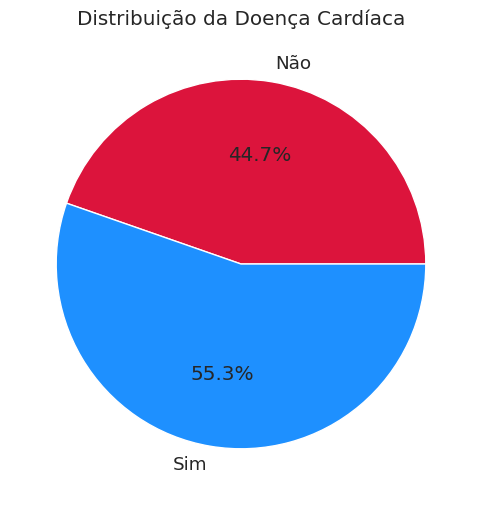

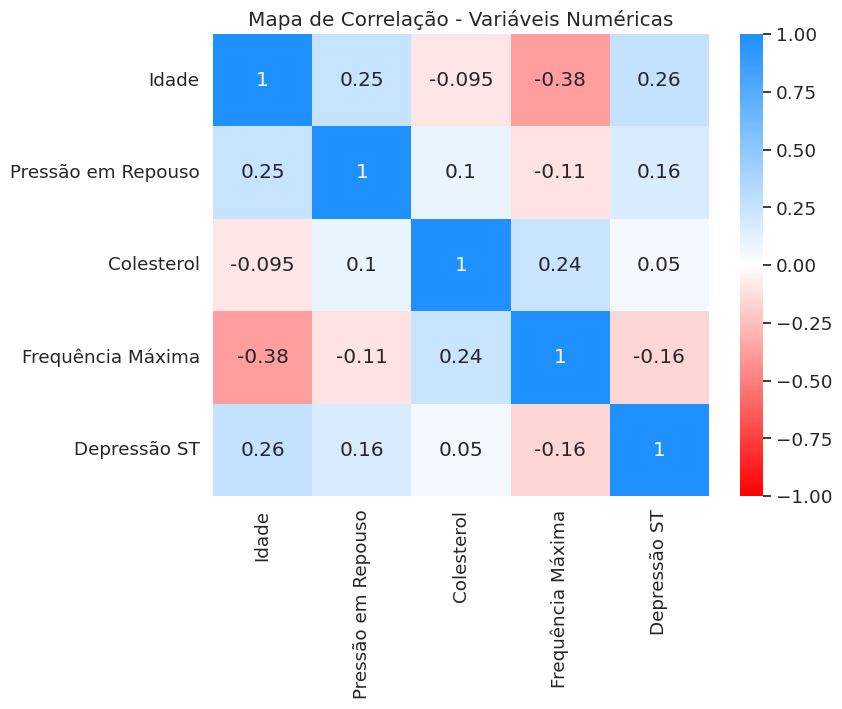

In [6]:
#DISTRIBUIÇÃO DE DOENÇA
datasetRedeNeural["Doença Cardíaca"].value_counts().reindex(["Não", "Sim"]).plot.pie(
    autopct="%1.1f%%",
    figsize=(6, 6),
    title="Distribuição da Doença Cardíaca",
    colors=['crimson', 'dodgerblue']
)

plt.ylabel("")
plt.show()

#HEATMAP DE CORRELAÇÃO
datasetRedeNeural_num = datasetRedeNeural[["Idade", "Pressão em Repouso", "Colesterol", "Frequência Máxima", "Depressão ST"]]

plt.figure(figsize=(8, 6))
sns.heatmap(
    datasetRedeNeural_num.corr(),
    annot=True,
    cmap=LinearSegmentedColormap.from_list("crimson_dodger", ['red', 'white', 'dodgerblue']),
    vmin=-1, vmax=1
)

plt.title("Mapa de Correlação - Variáveis Numéricas")
plt.show()

## **Modelo**

In [7]:
#DEFINIR VARIÁVEIS
datasetRedeNeural['Doença Cardíaca'] = datasetRedeNeural['Doença Cardíaca'].map({'Não': 0, 'Sim': 1})

XRedeNeural = datasetRedeNeural.drop("Doença Cardíaca", axis=1)
YRedeNeural = datasetRedeNeural["Doença Cardíaca"]

XRedeNeural = pd.get_dummies(XRedeNeural, drop_first=True)

#DIVISÃO EM TREINO E TESTE
XRedeNeural_treino, XRedeNeural_teste, YRedeNeural_treino, YRedeNeural_teste = train_test_split(XRedeNeural, YRedeNeural, test_size=0.2, stratify=YRedeNeural)

#ESCALONAR OS DADOS
scaler = StandardScaler()
XRedeNeural_treino = scaler.fit_transform(XRedeNeural_treino)
XRedeNeural_teste = scaler.transform(XRedeNeural_teste)

#TREINO DO MODELO
modeloRedeNeural = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping=True,
    random_state=42
)
modeloRedeNeural.fit(XRedeNeural_treino, YRedeNeural_treino)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(32, 16), max_iter=1000,
              random_state=42)

Acurácia da Rede Neural: 86.41%

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        82
           1       0.85      0.92      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



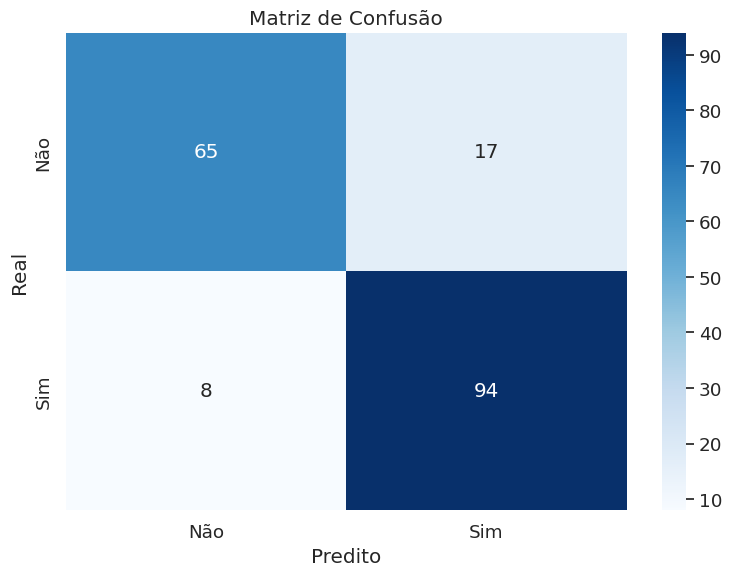

In [8]:
#PREVISÕES
YRedeNeural_pred = modeloRedeNeural.predict(XRedeNeural_teste)

#AVALIAÇÃO DO MODELO
acuracia = accuracy_score(YRedeNeural_teste, YRedeNeural_pred)
print(f"Acurácia da Rede Neural: {acuracia:.2%}\n")

print(classification_report(YRedeNeural_teste, YRedeNeural_pred))

CM = confusion_matrix(YRedeNeural_teste, YRedeNeural_pred)
labels = ['Não', 'Sim']

plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

## **Extra**

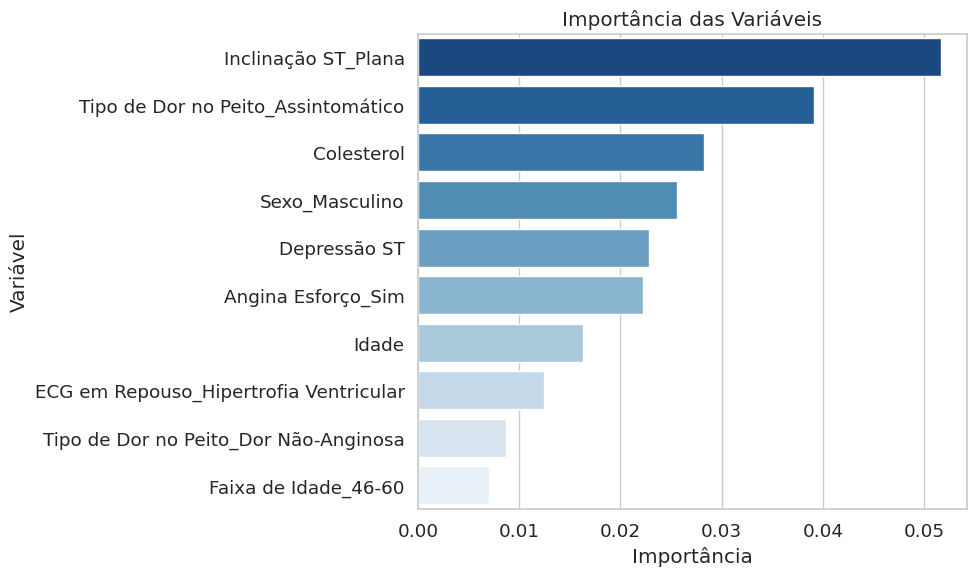

In [9]:
from sklearn.inspection import permutation_importance

resultado_importancia = permutation_importance(
    modeloRedeNeural, XRedeNeural_teste, YRedeNeural_teste, n_repeats=10, random_state=42
)

importancia_df = pd.DataFrame({
    'Variável': XRedeNeural.columns,
    'Importância': resultado_importancia.importances_mean
}).sort_values(by='Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importancia_df.head(10),
    x='Importância',
    y='Variável',
    hue='Variável',
    dodge=False,
    palette='Blues_r',
    legend=False
)
plt.title('Importância das Variáveis')
plt.tight_layout()
plt.show()